<h2><font color="#004D7F" size=6>Módulo 4. Fase de tratamiento de datos</font></h2>



<h1><font color="#004D7F" size=5>3. Feature Importance</font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Manuel Castillo-Cara</font><br>
<font color="#004D7F" size=3>Machine Learning con Python</font><br>

---

<h2><font color="#004D7F" size=5>Índice</font></h2>
<a id="indice"></a>

* [1. Introducción](#section1)
    * [1.1. Librerías y CSV](#section11)
* [2. Métricas de clasificación](#section2)
    * [2.1. Decision Trees](#section21)
    * [2.2. Extra Trees](#section22)
    * [2.3. Random Forest](#section23)
    * [2.4. LASSO](#section24)
* [3. Reducción de dimensiones](#section3)

In [1]:
# Permite ajustar la anchura de la parte útil de la libreta (reduce los márgenes)
from IPython.core.display import display, HTML
display(HTML("<style>.container{ width:98% }</style>"))

C:\Users\Maxi Mores\AppData\Local\Temp\ipykernel_4184\1126351303.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


---

<a id="section1"></a>
# <font color="#004D7F"> 1. Introducción</font>

En resumen, feature selection, también llamado como selección de mejores características o atributos, es el proceso de seleccionar un subconjunto de características pertinentes (variables, predictores) para su uso en construcción de modelos. Las técnicas de feature selection son utilizadas por cuatro razones:
* Simplificación de modelos con el fin de hacerlas más sencillas de interpretar para los usuarios/investigadores.
* Menor tiempo de entrenamiento.
* Evitar la maldición de la dimensionalidad:
* Generalización realzada por reducir _overfitting_ (formalmente, reducción de varianza).

<a id="section11"></a>
## <font color="#004D7F"> 1.1. CSV</font>

En esta lección, se muestran varias métricas de evaluación de algoritmos diferentes para problemas de Machine Learning de clasificación y regresión. En cada código, el conjunto de datos se descarga directamente del repositorio de UCI Machine Learning.
* **Clasificación**: se usará el conjunto de datos de Pima Indians Diabetes. Este es un problema de clasificación binaria donde todas las características de entrada son numéricas.

In [2]:
# Clasification problem
import pandas as pd
filename = 'data/pima-indians-diabetes.data.csv'
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class'] 
df_cla = pd.read_csv(filename, names=names)
array = df_cla.values
X_cla = array[:,0:8]
Y_cla = array[:,8]

In [3]:
# Clasification problem (imported and binary)
import pandas as pd
from sklearn.datasets import load_breast_cancer
wisconsin = load_breast_cancer()
df_wisconsin = pd.DataFrame(wisconsin.data, columns = wisconsin.feature_names) # cargamos en el df solo las características (data)
X_wisconsin = wisconsin.data # nuestras características
y_wisconsin = wisconsin.target # nuestra clase

* **Regresión**: se usará el conjunto de datos Boston House Price. Este es un problema de regresión donde todas las características de entrada también son numéricas. En esta práctica lo trabajaremos directamente desde scikit-learn.

In [4]:
# Ya no esixte el dataset público por lo que lo cargamos directamente de nuestro CSV
# Regression problem
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
filename_reg = 'data/housing.csv'
names_reg = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO',
'B', 'LSTAT', 'MEDV']
df_reg = pd.read_csv(filename_reg, delim_whitespace=True, names=names_reg) 
array_reg = df_reg.values
X_reg = array_reg[:,0:13]
y_reg = array_reg[:,13]

<a id="section12"></a>
## <font color="#004D7F"> 1.2. Librerías</font>

Por último vamos a declarar algunas librerías generales que ya hemos estado trabajando y que usaremos a lo largo de la sección.

In [5]:
#importing libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split

<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<a id="section2"></a>
# <font color="#004D7F"> 2. Técnicas de Feature Importance</font>

La importancia de las características se puede estimar a partir de datos mediante la construcción de un modelo. Algunos métodos como los árboles de decisión tienen un mecanismo incorporado para informar sobre la importancia variable. Para otros algoritmos, la importancia se puede estimar utilizando un análisis de curva ROC realizado para cada atributo. Aunque veremos algunos de estos modelos pueden utilizarse muchos otros.

<a id="section21"></a>
## <font color="#004D7F"> 2.1. Decision Trees </font>

Los árboles de decisión hacen un particionamiento del espacio de entrada mediante una estrategia voraz. En cada paso, eligen la variable óptima. Si se limita la profundidad del árbol, también se limita el número de nodos y, por tanto, el número de variables, por ejemplo, un árbol (variables contínuas) con profundidad 5 tendría a como máximo 63 nodos (26 - 1). Por tanto, utilizaría, a lo sumo, 63 variables.

Podemos observar que el resultado que el mejor resultado se obtiene utilizando 6 de las 30 variables originales

<div class="alert alert-block alert-info">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
En el vídeo se puede ver una errata de que utilizo Regressor. Al ser un problema de clasificación hay que utilizar Classifier como se encuentra en el código de la caja.
</div> 

In [6]:
# Busca combinaciones de características que puedan brindar un mayor grado de explicación de los datos de entrenamiento (que sirven luego para predecir sobre los datos de validación)
from sklearn.tree import DecisionTreeRegressor # para ver características más importantes (si es problema de Clasificación "DecisionTreeClassifier")
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Genera la partición
X_train,X_test,Y_train,Y_test = train_test_split(X_wisconsin,y_wisconsin,test_size=0.2,random_state=7) # partición de 80/20
# Como según el valor de random_state cambia la forma en que se dividen los datos, puedo tomar un array del [0-9] del mismo y hacer un promedio del rendimiento del modelo con datos de prueba y validación
# Aprende el modelo
depth = 9 # profundidad de 3 (con produndidad de 2 tenemos algo de Underfitting y mayor predicción de datos de validación, con 3 muy poco Overfitting)
tree = DecisionTreeRegressor(criterion='squared_error', max_depth=depth) # criterio del arbol: MSE 
tree.fit(X_train,Y_train) # entreno al modelo
# Extrae los índices de las variables utilizadas
subset = np.unique(tree.tree_.feature[tree.tree_.feature >= 0]) # me muestra las características que utilizó el arbol
print("Variables: ", X_wisconsin.shape[1]) # me imprime la cantidad de variables o características (filas=0,columnas=1)
print("Variables utilizadas: ", subset) # me aclara cuáles variables han obtenido mejor resultado (corroborar en df)
print("Training: ", tree.score(X_train,Y_train).round(2)) # efectividad del modelo para con los datos de prueba
print("Test: ", tree.score(X_test,Y_test).round(2)) # efectividad del modelo para con los datos de validación
print(df_wisconsin.columns[1],df_wisconsin.columns[14],df_wisconsin.columns[21],
      df_wisconsin.columns[23],df_wisconsin.columns[26],df_wisconsin.columns[27]) # vemos las características con que llegó al resultado
# Entre ambos coeficientes podemos ver si se produce Overfitting (si la predicción con los datos de prueba es mucho más efectiva que con los de validación)
# o Underfitting (si la predicción con los datos de prueba es baja o con los de validación es mucho más alto).
# Lo ideal es que los 2 sean similares, pudiendo cambiar la profundidad para lograrlo (si la bajo se ajusta menos al entrenamiento y reduzco Overfitting y si la subo se ajusta más al entrenamient y reduzco Underfitting)
# En cada ejecución también cambian los resultados y parámetros usados

Variables:  30
Variables utilizadas:  [ 0  1  6 11 13 14 21 23 25 26 27]
Training:  1.0
Test:  0.77
mean texture smoothness error worst texture worst area worst concavity worst concave points


In [7]:
# Si buscamos obtener un valor más obejtivo del rendimiento del modelo y medir la sensibilidad de la partición de los datos en train/test, 
# podemos hacer un promedio de los rendimientos obtenidos cambiando el valor de random_state en la partición
# También podemos tomar las características que más se repiten en los mejores resultados con respecto al test
from sklearn.tree import DecisionTreeRegressor # si es problema de Regresión "DecisionTreeRegressor"
from sklearn.model_selection import train_test_split
import numpy as np

# Suponiendo que X_wisconsin y y_wisconsin están definidos
random_states = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # puedes usar más valores para una mejor estimación
depth = 3
train_scores = []
test_scores = []

for state in random_states:
    X_train, X_test, Y_train, Y_test = train_test_split(X_wisconsin, y_wisconsin, test_size=0.2, random_state=state)
    tree = DecisionTreeRegressor(criterion='squared_error', max_depth=depth)
    tree.fit(X_train, Y_train)
    
    train_score = tree.score(X_train, Y_train)
    test_score = tree.score(X_test, Y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(f"Random state: {state}")
    print("Variables: ", X_wisconsin.shape[1])
    print("Variables utilizadas: ", np.unique(tree.tree_.feature[tree.tree_.feature >= 0]))
    print("Training: ", train_score.round(2))
    print("Test: ", test_score.round(2))
    print()

# Promedios de las métricas
avg_train_score = np.mean(train_scores)
avg_test_score = np.mean(test_scores)

print("Promedio Training: ", avg_train_score.round(2))
print("Promedio Test: ", avg_test_score.round(2))

Random state: 0
Variables:  30
Variables utilizadas:  [ 4  8 10 22 23 27]
Training:  0.9
Test:  0.85

Random state: 1
Variables:  30
Variables utilizadas:  [ 7 13 20 21 22 27]
Training:  0.91
Test:  0.75

Random state: 2
Variables:  30
Variables utilizadas:  [21 22 27]
Training:  0.9
Test:  0.7

Random state: 3
Variables:  30
Variables utilizadas:  [11 13 20 23 26 27]
Training:  0.9
Test:  0.7

Random state: 4
Variables:  30
Variables utilizadas:  [13 21 22 23 24 27 29]
Training:  0.91
Test:  0.47

Random state: 5
Variables:  30
Variables utilizadas:  [ 4 21 22 23 26 27]
Training:  0.89
Test:  0.89

Random state: 6
Variables:  30
Variables utilizadas:  [ 5 13 22 23 24 27 29]
Training:  0.9
Test:  0.67

Random state: 7
Variables:  30
Variables utilizadas:  [ 1 21 23 26 27]
Training:  0.9
Test:  0.76

Random state: 8
Variables:  30
Variables utilizadas:  [ 6  7 10 20 21 22 27]
Training:  0.88
Test:  0.73

Random state: 9
Variables:  30
Variables utilizadas:  [ 1 20 21 26 27]
Training:  0

<div class="alert alert-block alert-info">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
En este caso tenemos que tener mucho cuidado con la profundidad del árbol que utilizamos porque podemos caer en _overfitting._
</div> 

Con la herramienta **graphviz** y **pydotplus** podemos ver como quedaría construído el árbol. En el caso de sistemas Linux deberás instalarla también en su máquina original `sudo apt install graphviz`.

In [8]:
#!pip install  graphviz
#!pip install pydotplus

<div class="alert alert-block alert-info">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Nota 1__: Para poder ver el árbol hay que proceder a la instalación de graphiz, en Linux, SO que tengo, se instala como está indicado. Para Windows se tendría que seguir los pasos del PDF que hay en esta misma sesión. Recuerda reniciar Anaconda una vez instaladas las librerías
</div> 

<div class="alert alert-block alert-info">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Nota 2__: La librería _six_ ha cambiado en la última versión, no modifique el código que se encuentra a continuación ya que en el vídeo se encuentra en una versión anterior.
</div> 

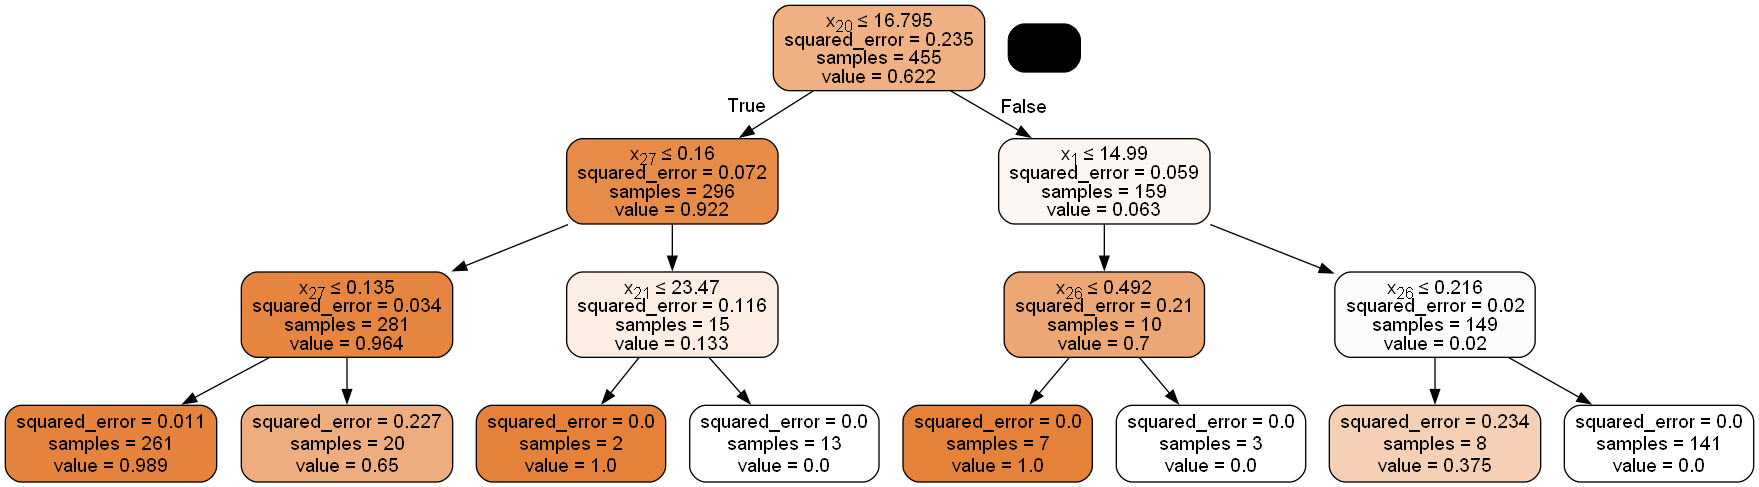

In [9]:
# Para mostrar como ha generado el árbol
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import six
import sys
sys.modules['sklearn.externals.six'] = six
from six import StringIO

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True) # ponemos nuestro objeto árbol aca
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
# Samples sería instancias que llegaron a ese nodo (después de aplicar condiciones anteriores), Value seríael valor promedio de la variable de salida (dependiente) para las muestras en ese nodo (punto de corte, es el valor de predicción que el modelo daría para cualquier muestra que llegue a este nodo) y squared_error es el MSE
# En el primer caso, cuando X20 es menor o igual a 16.795 va por la izquiera, y cuando es mayor por la derecha, si es verdadero, toma la X27 por ser la que más muestras tiene y menor MSE
# Lo que se busca es minimizar el MSE del modelo, para predecir mejor

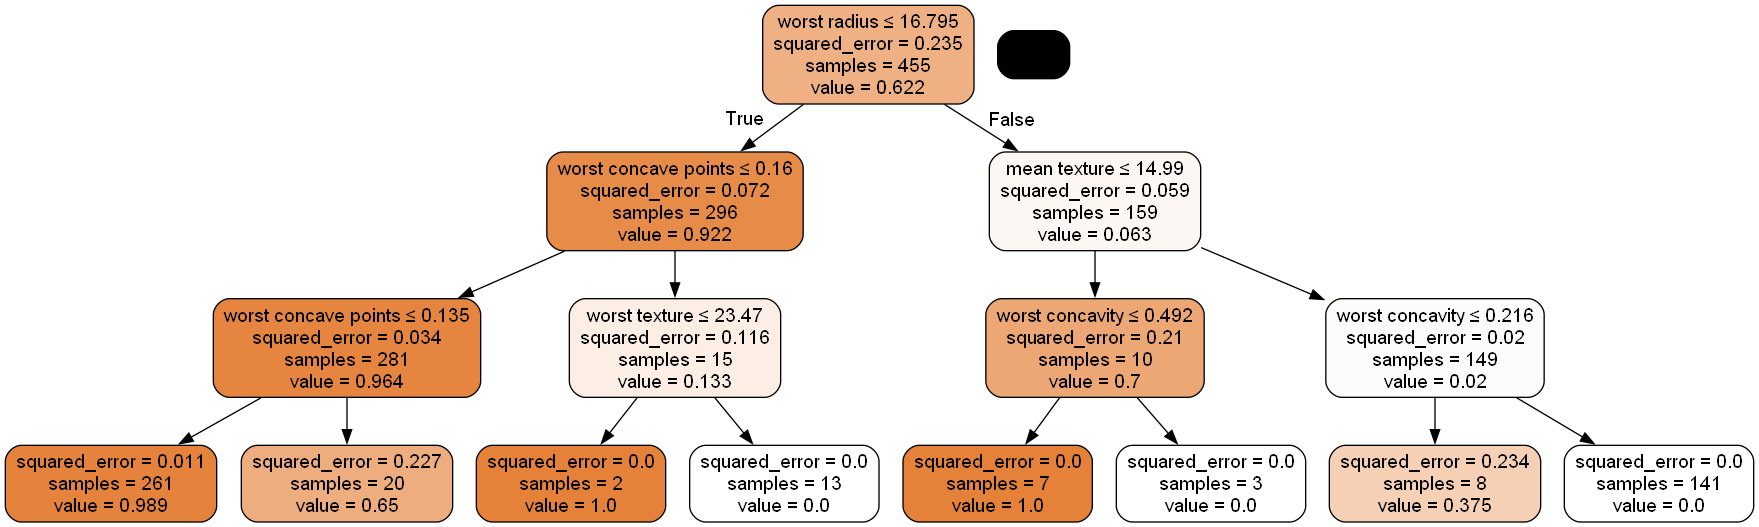

In [10]:
# Si le queremos incluir los nombres de las variables
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from io import StringIO

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                feature_names=df_wisconsin.columns, # agrego los nombres de las características desde el df de Wisconsin
                class_names=True) # Si tienes nombres para las clases en una clasificación agrego esta linea

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

<a id="section22"></a>
## <font color="#004D7F"> 2.2. Extra Trees </font>

Se pueden usar árboles de decisión tipo bagged como Random Forest y Extra Trees para estimar la importancia de las características. En el siguiente ejemplo, construimos un clasificador `ExtraTreesClassifier` para el inicio del conjunto de datos de diabetes de Pima Indians. 

Puede ver que se nos da un puntaje de importancia para cada atributo, donde cuanto mayor es el puntaje, más importante es el atributo. Los puntajes sugieren la importancia de _plas, age_ y _mass._

In [11]:
from sklearn.ensemble import ExtraTreesClassifier # si es problema de Regresión "ExtraTreesRegressor"
# extracción de características
model = ExtraTreesClassifier() # podemos aclarar número de árboles y profundidad con "max_depth=", pero si lo dejamos sin identificar el algoritmo determina la profundidad hasta el punto que no comience a generar Overfitting
model.fit(X_cla,Y_cla)
print(list(df_cla.columns)) # características del df (ignorar clase)
print(model.feature_importances_) # importancia de cada característica para la predicción del modelo (plas,age,mass)
# podemos poner model. y ver las statement que tiene para obtener información de como procedió para asignarle importancia a las características (base_estimator_,classes_,criterion,max_depth,max_leaf_nodes(num nodos),n_estimators(num árboles))
# Extra Trees construye varios árboles de decisión de manera más automática

['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
[0.11260584 0.23826824 0.0989164  0.07635746 0.0748187  0.13980669
 0.11814753 0.14107914]


<div class="alert alert-block alert-info">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Puede obtener más información sobre la clase [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)
</div> 

<a id="section23"></a>
## <font color="#004D7F"> 2.3. Random Forest </font>

En su formulación original, el algoritmo Random Forest computa también la importancia de las variables

In [23]:
# La más usada en el análisis de características. También crea muchos árboles, pero pone la profundidad hasta que en una rama queden representados todos los atributos.
# Al árbol no le interesa si incurre en Overfitting o no en este caso
# Computa el error de diferentes modelos (incluyendo o no variables) para identificar variables relevantes
from sklearn.ensemble import RandomForestClassifier # Regressor si es un problema de Regresión
from sklearn.metrics import accuracy_score

# Genera la partición
X_train, X_test, Y_train, Y_test = train_test_split(X_wisconsin, y_wisconsin, test_size=0.33, random_state=0)
# Entrenamos al algoritmo con todas las características
forest = RandomForestClassifier(n_estimators=100) # número de árboles (100)
forest.fit(X_train, Y_train) # entreno el 'bosque' de árboles
# Extrae las importancias
importances = forest.feature_importances_
y_pred = forest.predict(X_test) # predicción
print(f"Precisión (con todas las variables): {accuracy_score(Y_test, y_pred)}") # Compruebo la eficacia del modelo con respecto a los datos de validación
# (Accuracy o demás estimadores para Clasificación, MSE o R2 entre otros para Regresión)
# Si tuviera poca precisión (menor a 0.75) podría considerar seleccionar las características más relevantes para simplificar el modelo y ganar capacidad predictiva

Precisión (con todas las variables): 0.9627659574468085


In [ ]:
# Si fuera de Regresión procederíamos así
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Supongamos que df_reg es tu DataFrame y tiene la variable objetivo llamada 'target'
X = df_reg.drop(columns=['target'])
Y = df_reg['target']

# Genera la partición
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Entrenamos al algoritmo con todas las características
forest = RandomForestRegressor(n_estimators=100) # número de árboles (100)
forest.fit(X_train, Y_train) # entreno el 'bosque' de árboles

# Extrae las importancias
importances = forest.feature_importances_

# Predicción
y_pred = forest.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"Mean Squared Error (con todas las variables): {mse}")
print(f"R² (con todas las variables): {r2}")

# Mostrar importancia de características
print("Importancia de las características:")
for i, col in enumerate(X.columns):
    print(f"{col}: {importances[i]}")

In [24]:
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(forest.feature_importances_)
print(wisconsin.feature_names[ranking]) # me muestra por orden de importancia las variables para el modelo

['mean fractal dimension' 'smoothness error' 'concavity error'
 'compactness error' 'symmetry error' 'concave points error'
 'mean symmetry' 'fractal dimension error' 'texture error'
 'mean smoothness' 'worst fractal dimension' 'mean compactness'
 'worst texture' 'worst symmetry' 'worst smoothness' 'worst compactness'
 'mean texture' 'radius error' 'perimeter error' 'mean radius' 'mean area'
 'worst concavity' 'area error' 'mean perimeter' 'mean concavity'
 'worst radius' 'worst perimeter' 'mean concave points'
 'worst concave points' 'worst area']


Características ordenadas por importancia:
mean fractal dimension: 0.0029
smoothness error: 0.0032
concavity error: 0.0039
compactness error: 0.0040
symmetry error: 0.0042
concave points error: 0.0047
mean symmetry: 0.0049
fractal dimension error: 0.0052
texture error: 0.0054
mean smoothness: 0.0068
worst fractal dimension: 0.0070
mean compactness: 0.0104
worst texture: 0.0115
worst symmetry: 0.0118
worst smoothness: 0.0136
worst compactness: 0.0145
mean texture: 0.0145
radius error: 0.0158
perimeter error: 0.0221
mean radius: 0.0298
mean area: 0.0304
worst concavity: 0.0323
area error: 0.0340
mean perimeter: 0.0548
mean concavity: 0.0588
worst radius: 0.0702
worst perimeter: 0.1216
mean concave points: 0.1264
worst concave points: 0.1367
worst area: 0.1385


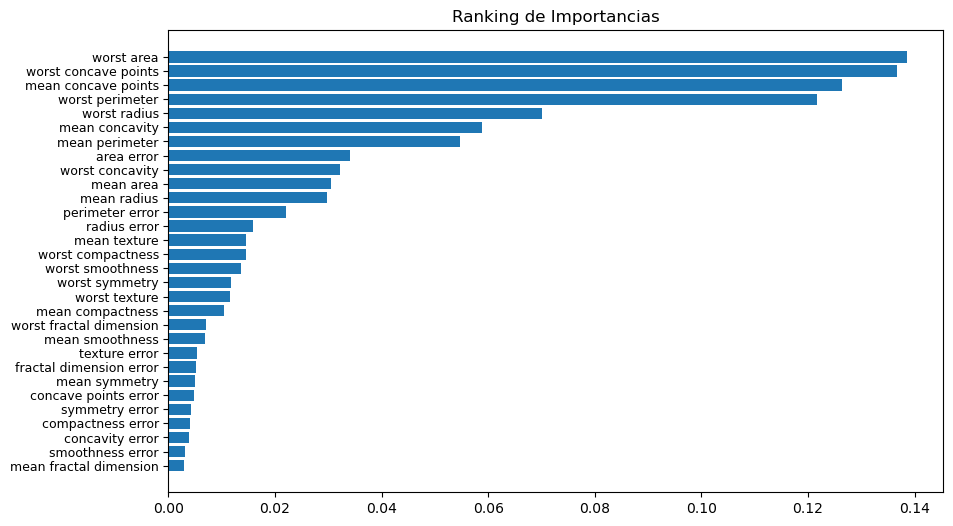

In [25]:
# Imprime los nombres de las características ordenadas por importancia
feature_names = X_wisconsin.columns if isinstance(X_wisconsin, pd.DataFrame) else wisconsin.feature_names
print("Características ordenadas por importancia:")
for idx in ranking:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")
# Visualizo los índices de importancia de las característcas ordenados de menor a mayor en un gráfico de barras
plt.figure(figsize=(10,6))
plt.title("Ranking de Importancias")
plt.barh(range(X_wisconsin.shape[1]),importances[ranking]) # pido que me muestre las características por el ranking creado por el Random Forest (contenido del barplot)
plt.yticks(range(X_wisconsin.shape[1]),wisconsin.feature_names[ranking],fontsize=9) # configuro el eje Y
plt.show()
# Worst Concave Points sería la más importante, Mean concave Points la siguiente y así
# Podemos delimitar hasta el punto que consideremos importantes a características 

Y con estas características podemos ver si ha mejorado nuestros resultados eliminando las 5 características que, según Random Forest tenían menos importancia.

In [26]:
# Produzcamos predicciones sin tomar las 5 peores características según el Random Forest
selected_features = ranking [:-5] # tomo todo menos las últimas 5 características
# ranking [-5:] para las peores 5 características, ranking [:5] para las mejores 5 características, etc
forest.fit(X_train.iloc[:, selected_features], Y_train)
Y_pred_selected = forest.predict(X_test.iloc[:, selected_features]) # tampoco para el testeo tomamos el resto de características
print(f"Precisión(con las primeras 5 características): {accuracy_score(Y_test, Y_pred_selected)}") # hacer con MSE y R2 en Regresión
# Ver hasta que punto estoy dispuesto a perder precisión en el modelo por eliminar características

Precisión(con las primeras 5 características): 0.9468085106382979


<a id="section24"></a>
## <font color="#004D7F"> 2.4. LASSO </font>

La importancia de las características se puede estimar a partir de los datos mediante la construcción de un modelo. Algunos métodos como los árboles de decisión tienen un mecanismo incorporado para informar sobre la importancia variable. Para otros algoritmos, la importancia se puede estimar utilizando un análisis de curva ROC realizado para cada atributo.

En este caso el modelo LASSO ha tomado todas las características excepto _NOX, CHAS_ e _INDUS._ Así mismo podemos utilizar otros modelos como RIDGE o Linear Regression por ejemplo.

<div class="alert alert-block alert-info">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
No cambiar el código que se encuentra en el cuadro ya que ha sido acatualizdo respecto al vídeo. 
</div> 

Mejor alpha usando LassoCV: 0.7248204283772595
Mejor score usando LassoCV: 0.7024437179872696
         Coefficient
CRIM       -0.074266
ZN          0.049454
INDUS      -0.000000
CHAS        0.000000
NOX        -0.000000
RM          1.804385
AGE         0.011333
DIS        -0.813244
RAD         0.272284
TAX        -0.015425
PTRATIO    -0.742872
B           0.008926
LSTAT      -0.703654
Lasso eligió 10 variables y eliminó las otras 3 variables


Text(0.5, 1.0, 'Importancia de características usando modelo de Lasso')

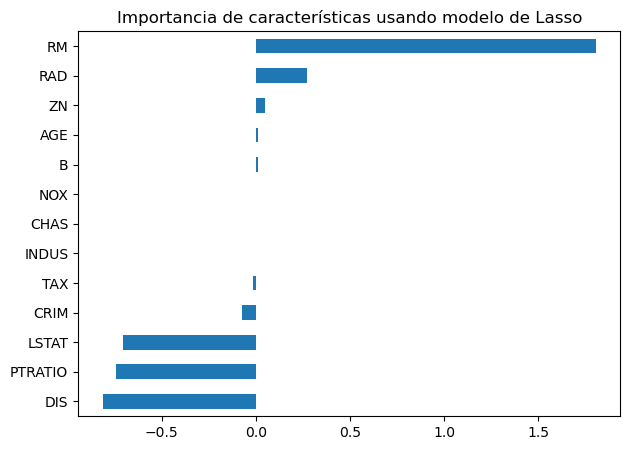

In [20]:
# Lasso es un tipo de regresión lineal (para problemas de regresión) que aplica penalizaciones a características
from sklearn.linear_model import LassoCV
# Importancia de las características
reg = LassoCV()
reg.fit(X_reg,y_reg) # hago la regresión con todos los datos

print(f"Mejor alpha usando LassoCV: {reg.alpha_}") # el valor del hiperparámetro utilizado por Lasso
print(f"Mejor score usando LassoCV: {reg.score(X_reg,y_reg)}") # 
coef = pd.DataFrame(reg.coef_, df_reg.columns[0:13], columns=['Coefficient']) # configuro el df (data,filas(index),columnas) (poner [0:n] ) siendo 'n' el número de características (suponiendo que ubicamos a la clase última)
print(coef) # me muestra los coeficientes que le ha dado Lasso a las características

# Características elegidas y eliminadas
print("Lasso eligió " + str(sum(coef['Coefficient'] != 0)) + " variables y eliminó las otras " 
      +  str(sum(coef['Coefficient'] == 0)) + " variables") # me elige los coeficientes distintos de 0 y me descarta los iguales a 0 (NOX,CHAS,INDUS)

# Mostrar coeficientes
imp_coef = coef['Coefficient'].sort_values() # ordeno los valores del df de mayor a menor
plt.rcParams['figure.figsize'] = (7.0,5.0)
imp_coef.plot (kind='barh') # tipo de gráfico de barra horizontal
plt.title("Importancia de características usando modelo de Lasso")

# Las características con barras nulas o casi nulas son las que aportan menos (o nula) información al modelo. Se nos descartan directamente las barras nulas
# Podemos también proponer eliminar AGE,B,TAX del algoritmo por su poca importancia también

<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<a id="section3"></a>
# <font color="#004D7F"> 3. Reducción de dimensiones </font>

PCA es un procedimiento estadístico que utiliza una transformación ortogonal que convierte un conjunto de variables correlacionadas en un conjunto de variables no correlacionadas. Es decir, identifica pautas en nuestro dato basado en las correlaciones entre características. Esta correlación implica que hay redundancia en nuestros datos, en otras palabras, que hay parte de los datos que se pueden explicar por relaciones con otras partes de los mismos.

Estos datos correlacionados no son necesarios para el aprendizaje correcto del modelo, y por tanto pueden ser eliminados. Se pueden eliminar borrando directamente ciertas columnas (características) o combinando un número de ellos y obteniendo nuevos datos que contengan la mayoría de la información. 

En este caso podemos ver que hemos creado 3 componentes con PCA, es decir, hemos sustituido las características originales por los 3 componentes que nos da este tipo de transformación.

In [28]:
# Usamos PCA para problema de Clasificación (reduce dimensiones de un conjunto de datos asumiendo y buscando la mayor varianza posible original)
# Resume muchas variables en unas pocas cuya varianza sea lo más parecida posible (analizar el trade off +variables -varianza captada de set original)
# La primer componente es la que asume la mayor varianza de nuestros datos
# Se utiliza mucho para aprendizaje no supervisado (creando cluster a partir de la reducción de características)
from sklearn.decomposition import PCA
# PCA con k=3 (con 3 componentes principales)
k = 3
pca = PCA(n_components=k) # número de componentes principales (buscar el 99% acumulado de varianza)
fit = pca.fit(X_cla)
X_transform = pca.transform(X_cla)
# Resumo componentes
C = pca.components_
print(f"Varianza explicada: {fit.explained_variance_ratio_}") # me muestra la varianza explicada por cada componente (descartar o agregar k según quiera captar más o menos varianza)
# Aproximadamente mis 3 componentes explican un 97% de la varianza del set original (con 8 características). Siempre se pierde información
print(f"Components: {C}") # mostramos los componentes creados (vectores)
# Convertimos a df nuestros componentes
df_pca = pd.DataFrame(data=X_transform,columns=['PC1','PC2','PC3']) # la información de mi set original ahora se encuentra acá
df_pca.head(3) # el número de instancias originales no cambia

Varianza explicada: [0.88854663 0.06159078 0.02579012]
Components: [[-2.02176587e-03  9.78115765e-02  1.60930503e-02  6.07566861e-02
   9.93110844e-01  1.40108085e-02  5.37167919e-04 -3.56474430e-03]
 [-2.26488861e-02 -9.72210040e-01 -1.41909330e-01  5.78614699e-02
   9.46266913e-02 -4.69729766e-02 -8.16804621e-04 -1.40168181e-01]
 [-2.24649003e-02  1.43428710e-01 -9.22467192e-01 -3.07013055e-01
   2.09773019e-02 -1.32444542e-01 -6.39983017e-04 -1.25454310e-01]]


,PC1,PC2,PC3
0,-75.714655,-35.950783,-7.260789
1,-82.358268,28.908213,-5.496671
2,-74.630643,-67.906496,19.461808


Vemos que casi toda la varianza es explicada usando solo un componente, por lo que podría decirse que dicho componente contiene casi toda la información de las features. Ahora veamos cuáles son las variables que contribuyen más a dicho componente:

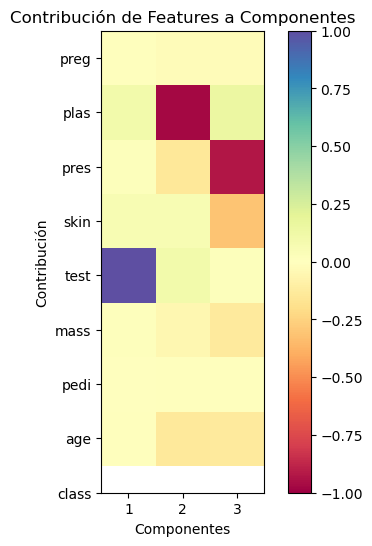

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(pca.components_.T, cmap="Spectral", vmin=-1, vmax=1)
plt.yticks(range(len(df_cla.columns.values)), df_cla.columns.values)
plt.xticks(range(3), range(1, 4))
plt.xlabel("Componentes")
plt.ylabel("Contribución")
plt.title("Contribución de Features a Componentes")
plt.colorbar()

<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>